# Goal

Employee turn-over is a very costly problem for companies. The cost of replacing an employee is often huge, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses, the loss of productivity for several months and impact on company morale when you see coworkers leave.

It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is often called people analytics or people data science (if you see a job title: people data scientist, this is the job).

In this challenge, you have a data set with info about the employees and you have to predict when employees are going to quit by understanding the main drivers of employee churn.

## Challenge Description

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:


1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id


2. What are the main factors that drive employee churn? Do they make sense? Explain your findings


3. If you could add to this data set just one variable that could help explain employee churn, what would that be?


## Data

In [20]:
import pandas as pd
import numpy as np
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

In [19]:
#read from google drive
data=pd.read_csv("./data/employee_retention_data.csv")
  
print(data.head())

   employee_id  company_id              dept  seniority    salary   join_date   quit_date
0      13021.0           7  customer_service         28   89000.0  2014-03-24  2015-10-30
1     825355.0           7         marketing         20  183000.0  2013-04-29  2014-04-04
2     927315.0           4         marketing         14  101000.0  2014-10-13         NaN
3     662910.0           7  customer_service         20  115000.0  2012-05-14  2013-06-07
4     256971.0           2      data_science         23  276000.0  2011-10-17  2014-08-22


- employee_id : id of the employee. Unique by employee per company

- company_id : company id. It is unique by company

- dept : employee dept

- seniority : number of yrs of work experience when hired

- salary: avg yearly salary of the employee during her tenure within the company

- join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13

- quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)


## First Question Solution
Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id

In [21]:
from datetime import datetime
  
#make them a date
data['join_date'] = pd.to_datetime(data['join_date']) 
data['quit_date'] = pd.to_datetime(data['quit_date']) 
  
#everything seems to make sense, some simple plots would help double check that
data.describe(include="all")

/var/folders/cx/bjmhwqx17hs884fsv84_cckh0000gn/T/ipykernel_57467/2056028482.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include="all")
/var/folders/cx/bjmhwqx17hs884fsv84_cckh0000gn/T/ipykernel_57467/2056028482.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include="all")


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702.000000,24702.000000,24702,24702.000000,24702.000000,24702,13510
unique,NaN,NaN,6,NaN,NaN,995,664
top,NaN,NaN,customer_service,NaN,NaN,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,NaN,NaN,9180,NaN,NaN,105,111
first,NaN,NaN,NaN,NaN,NaN,2011-01-24 00:00:00,2011-10-13 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2015-12-10 00:00:00,2015-12-09 00:00:00
mean,501604.403530,3.426969,NaN,14.127803,138183.345478,NaN,NaN
std,288909.026101,2.700011,NaN,8.089520,76058.184573,NaN,NaN
min,36.000000,1.000000,NaN,1.000000,17000.000000,NaN,NaN
25%,250133.750000,1.000000,NaN,7.000000,79000.000000,NaN,NaN


Let’s answer the question now. You should create a table with 3 columns: day, employee_headcount, company_id.

In [34]:
#create list of unique dates for the tables
unique_dates = pd.date_range(start='2011/01/24', end='2015/12/13')
  
#create list of unique companies
unique_companies = data['company_id'].unique()
  
#cross join so I get all combinations of dates and companies. Will need it later.
data_headcount = pd.MultiIndex.from_product([unique_dates, unique_companies], names = ["date", "company_id"])
data_headcount = pd.DataFrame(index = data_headcount).reset_index()
  
#now I get for each day/company, how many people quit/got hired on that day
data_join = data.groupby(['join_date', 'company_id']).size().reset_index(name='join_count')
data_join.columns.values[0]='date'
data_quit = data.groupby(['quit_date', 'company_id']).size().reset_index(name='quit_count')
data_quit.columns.values[0]='date'
  
#Now I left outer join with data_headcount. 
#NA means no people were hired/quit on that day cause there is no match.
data_headcount = pd.merge(data_headcount, data_join, on=["date", "company_id"], how='left')
data_headcount = pd.merge(data_headcount, data_quit, on=["date", "company_id"], how='left')
  
#replace the NAs with 0
data_headcount.fillna(0, inplace=True)
  
#Now I need the sum by company_id. Data set is already ordered by date, so I can simply group by company_id and do cumsum
data_headcount['cumsum_join'] = data_headcount.groupby(['company_id'])['join_count'].apply(lambda x: x.cumsum())
data_headcount['cumsum_quit'] = data_headcount.groupby(['company_id'])['quit_count'].apply(lambda x: x.cumsum())
  
#finally, for each date I just take join_count - quit_count and I am done
data_headcount['count'] = data_headcount['cumsum_join'] - data_headcount['cumsum_quit']
data_headcount_table = data_headcount[["date", "company_id","count"]]
  
#let's check company 1
print(data_headcount_table.query("company_id == 1").head(15))

          date  company_id  count
4   2011-01-24           1   25.0
16  2011-01-25           1   27.0
28  2011-01-26           1   29.0
40  2011-01-27           1   29.0
52  2011-01-28           1   29.0
64  2011-01-29           1   29.0
76  2011-01-30           1   29.0
88  2011-01-31           1   59.0
100 2011-02-01           1   66.0
112 2011-02-02           1   67.0
124 2011-02-03           1   67.0
136 2011-02-04           1   67.0
148 2011-02-05           1   67.0
160 2011-02-06           1   67.0
172 2011-02-07           1   99.0


In [23]:
#Another way to do it would be with a for loop. 
#intialize empty vectors
loop_cumsum = []
loop_date = []
loop_company = []
#loop through all days
for i in unique_dates:
  # loop through all companies
   for j in unique_companies:
        # count joins until that day
        tmp_join = data[(data['join_date'] <= i) & (data['company_id'] == j)].shape[0]
        # count quits
        tmp_quit = data[(data['quit_date'] <= i) & (data['company_id'] == j)].shape[0]
        loop_cumsum.append(tmp_join - tmp_quit) 
        loop_date.append(i)
        loop_company.append(j)
data_headcount_table_loop = pandas.DataFrame({ 'date': loop_date, 'company_id': loop_company, 'count': loop_cumsum})
#let's check company 1
print(data_headcount_table_loop.query("company_id == 1").head(15))

          date  company_id  count
4   2011-01-24           1     25
16  2011-01-25           1     27
28  2011-01-26           1     29
40  2011-01-27           1     29
52  2011-01-28           1     29
64  2011-01-29           1     29
76  2011-01-30           1     29
88  2011-01-31           1     59
100 2011-02-01           1     66
112 2011-02-02           1     67
124 2011-02-03           1     67
136 2011-02-04           1     67
148 2011-02-05           1     67
160 2011-02-06           1     67
172 2011-02-07           1     99


## Second Question Solution
Now let’s try to understand employee retention. Here the main challenge is about feature engineering. That is, extract variables from the quitting_date column.

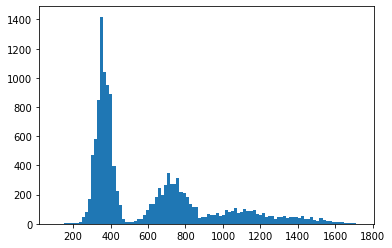

In [39]:
import matplotlib.pyplot as plt
  
#How many days were they employed? This should matter. People might get bored in the same place for too long
data['employment_length'] = (data['quit_date'] - data['join_date']).astype('timedelta64[D]')
  
#Let's plot employment length in days
plt.hist(data['employment_length'].dropna(), bins=100)
plt.show()

Very interesting, there are peaks around each employee year anniversary!

Now, let’s see if we find the characteristics of people who quit early. Looking at the histogram of employment_length, it looks like we could define early quitters as those people who quit within 1 yr or so. So, let’s create two classes of users : quit within 13 months or not (if they haven’t been in the current company for at least 13 months, we remove them)

In [40]:
from datetime import timedelta
#Create binary class
data=data[data['join_date'] <datetime.strptime("2015/12/13", "%Y/%m/%d") - timedelta(days=(365+31))]
data['early_quitter'] = np.where((data['employment_length']>396) | (np.isnan(data['employment_length'])), 0, 1)

Let’s now build a model. Here we can just care about: seniority, salary, dept, and company. A simple decision tree is probably more than enough.

In [44]:
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,early_quitter
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0
...,...,...,...,...,...,...,...,...,...
24695,63273.0,1,data_science,5,172000.0,2012-05-01,2015-06-26,1151.0,0
24696,94644.0,6,marketing,7,88000.0,2012-01-26,2013-02-01,372.0,1
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,780.0,0
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1123.0,0


In [41]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
data_dummy = pandas.get_dummies(data[['company_id', 'dept', 'seniority', 'salary', 'early_quitter']], drop_first=True)           
  
#we are not too interested in predictive power, we are mainly using the tree as a descriptive stat tool
tree = DecisionTreeClassifier( max_depth=4, min_samples_leaf = 30, class_weight="balanced", min_impurity_decrease = 0.001)
tree.fit(data_dummy.drop('early_quitter', axis=1), data['early_quitter'])
  
#visualize it
export_graphviz(tree, out_file="tree_employee.dot", feature_names=data_dummy.drop('early_quitter', axis=1).columns, proportion=True, rotate=True)
with open("tree_employee.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_employee.dot")
s.view()

'tree_employee.dot.pdf'

Not very surprising! Salary is what matters the most. After all, it probably has within it information about the other variables too. That is, seniority, dept and company impact salary. So salary carries pretty much all the information available.

It is interesting though that, looking at the terminal nodes, the way the tree split is: If salary between 224500 and 62500, the employee has higher probability of being an early quitter. That is, that’s a leaf that predicts class 1. Otherwise, the other two nodes predict class 0, which are >224500 and <62500. That means that <b>people who make a lot of money and very little are not likely to quit</b> (“little money” by Silicon Valley standards).

By plotting the proportion of early quitters by salary percentile, this becomes quite clear:

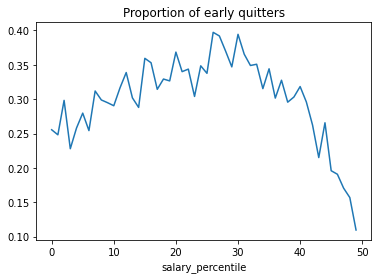

In [45]:
#convert salary to its percentiles. We break it into 50 bins.
data['salary_percentile'] = pandas.qcut(data['salary'],q=50, labels=False)
#take proportion of early quitters for each percentile value and plot it
data.groupby('salary_percentile')['early_quitter'].mean().plot(title="Proportion of early quitters")
plt.show()

## Conclusions



1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting. Understanding the trajectory of someone via their salaries at different time points could be really useful.


2. Employees tend to quit at year anniversaries. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait.


3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a harder time finding a new job. Obviously, those are totally different situations.


4. When building machine learning models on real data, you will find surprisingly often that one variable is way more important than the rest. We saw it in the conversion project too with number of pages visited. It is unlikely though that in real life one thing can explain complex phenomena. The most likely reason is that one variable is highly correlated with a lot of other variables. Like here, salary is obviously important, but especially because it is a proxy for so many other things (seniority, how marketable is someone, how much that person feels appreciated at work, etc). In these cases, assuming you have access to many other variables, try to get to the bottom of these relationships, by for instance building a model that predicts salary or removing salary and see which variables start to matter. After all, our model says that low salaries are less likely to quit. But definitely, it is not that if you reduce all salaries below 60K, retention will go up…